In [42]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import jax.random as jr

import optax
jax.config.update('jax_platform_name', 'cpu')


import numpy as np

import pickle

import sys
sys.path.append("..")

import lib



import matplotlib.pyplot as plt
plt.style.use(['../paper.mplstyle'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of lib.inference.gplvm failed: Traceback (most recent call last):
  File "/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 303, in update_instances
    ref.__class__ = new
  File "<string>", line 4, in __setattr__
dataclasses.FrozenInstanceError: cannot assign to field '__clas

## Load data

In [7]:
# binning
def binning(bin_size, spktrain):
    tbin, resamples, rc_t, (rhd_t, rth_t, rx_t, ry_t) = neural_utils.BinTrain(bin_size, sample_bin, spktrain, 
                                                        spktrain.shape[1], (np.unwrap(hd_t), np.unwrap(theta_t), x_t, y_t), 
                                                        average_behav=True, binned=True)


    rw_t = (rhd_t[1:]-rhd_t[:-1])/tbin
    rw_t = np.concatenate((rw_t, rw_t[-1:]))

    rvx_t = (rx_t[1:]-rx_t[:-1])/tbin
    rvy_t = (ry_t[1:]-ry_t[:-1])/tbin
    rs_t = np.sqrt(rvx_t**2 + rvy_t**2)
    rs_t = np.concatenate((rs_t, rs_t[-1:]))
    rtime_t = np.arange(resamples)*tbin

    units_used = rc_t.shape[0]
    rcov = (rx_t, ry_t, tools.WrapPi(rth_t, True), rs_t, tools.WrapPi(rhd_t, True), rw_t, rtime_t)
    return rcov, units_used, tbin, resamples, rc_t

In [8]:
session_id = 'hc5_15'
data = np.load('../data/{}.npz'.format(session_id))
spktrain = data['spktrain']
x_t = data['x_t']
y_t = data['y_t']
s_t = data['s_t']
dir_t = data['dir_t']
hd_t = data['hd_t']
theta_t = data['theta_t']
arena = data['arena']

sample_bin = 0.0008

left_x, right_x, bottom_y, top_y = arena
units_used = spktrain.shape[0]

In [ ]:
from scipy.signal import hilbert


data = np.load('./checkpoint/hc5_13_eeg.npz')


# hilbert signal of filtered
eeg_filt = utils.signal.filter_signal(eeg_t, 5., 12., sample_bin)

analytic_signal = hilbert(eeg_filt[:])
#hilbert_amp = np.abs(analytic_signal)
hilbtheta_t = np.unwrap(np.angle(analytic_signal))

In [9]:
spktrain.shape

(34, 4519193)

In [16]:
lagged_ISIs = lib.utils.neural.get_lagged_ISIs(spktrain.T, 3)

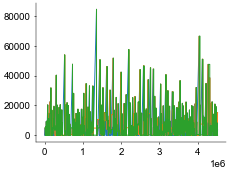

In [17]:
n = 0

plt.plot(lagged_ISIs[:, n, 0])
plt.plot(lagged_ISIs[:, n, 1])
plt.plot(lagged_ISIs[:, n, 2])

In [35]:
ind = np.isnan(lagged_ISIs.sum(1).sum(1)).astype(float)
start_timestep = np.where((ind[1:] - ind[:-1]) < 0.)[0][0]+1

In [36]:
lagged_ISIs[start_timestep:, ...]

DeviceArray(2.1979743e+12, dtype=float32)

## Modulated renewal process

In [2]:
x_dims = 2
f_dims = 3
neurons = f_dims
dt = 1.  # ms

jitter = 1e-12

n_samp = 10

prng_state = jax.random.PRNGKey(123)

In [10]:
len_fx = 1.*np.ones((f_dims, x_dims))  # GP lengthscale
var_f = 1.*np.ones(f_dims)  # observation noise
kern = lib.GP.kernels.SquaredExponential(f_dims, variance=var_f, lengthscale=len_fx)
mean_f = np.zeros(f_dims)


### inducing points ###
num_induc = 5
induc_locs = jax.random.normal(prng_state, shape=(f_dims, num_induc, x_dims))
prng_state, _ = jr.split(prng_state)


u_mu = 1. + 0.*jax.random.normal(prng_state, shape=(f_dims, num_induc, 1))
u_Lcov = 0.01*jnp.eye(num_induc)[None, ...].repeat(f_dims, axis=0)
prng_state, _ = jr.split(prng_state)


svgp = lib.GP.sparse.qSVGP(kern, mean_f, induc_locs, u_mu, u_Lcov, RFF_num_feats=0)

Kzz = svgp.kernel.K(svgp.induc_locs, None, False)
lambda_1, chol_Lambda_2 = lib.GP.sparse.t_from_q_svgp_moments(Kzz, u_mu, u_Lcov)


In [11]:
renewal_type = 'lognorm'

if renewal_type == 'gamma':
    alpha = np.linspace(0.5, 1.5, neurons)
    renewal = lib.likelihoods.renewal.Gamma(
        neurons,
        dt,
        alpha,
    )
    
elif renewal_type == 'lognorm':
    sigma = np.linspace(0.5, 1.5, neurons)
    renewal = lib.likelihoods.renewal.LogNormal(
        neurons,
        dt,
        sigma,
    )
    
elif renewal_type == 'invgauss':
    mu = np.linspace(0.5, 1.5, neurons)
    renewal = lib.likelihoods.renewal.InverseGaussian(
        neurons,
        dt,
        mu,
    )

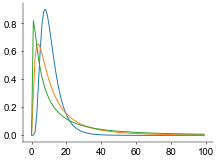

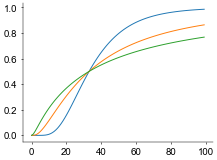

In [13]:
ISI = jnp.linspace(0.001, 10., 100)[:, None]
ll = jax.vmap(renewal.log_renewal_density)(ISI)
plt.plot(jnp.exp(ll)[:, :])
plt.show()

ISI = jnp.linspace(0.001, 3., 100)[:, None]
ll = jax.vmap(renewal.cum_renewal_density)(ISI)
plt.plot(ll[:, :])
plt.show()

In [35]:
mrp = lib.inference.gplvm.RenewalGPLVM(svgp, renewal)

In [36]:
t_eval = jnp.linspace(0, 10, 100)
x_cond = jnp.zeros((2, f_dims, x_dims))

jitter = 1e-6

renewal_density = mrp.sample_instantaneous_renewal(
    prng_state, t_eval, x_cond, jitter, num_samps = 20, prior = True)

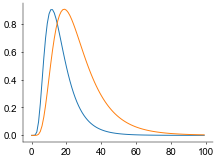

In [41]:
s = 0
n = 0

plt.plot(renewal_density[:, n, :].T)

In [ ]:
rho_t = mrp.evaluate_conditional_intensity(
    prng_state, t_eval, x_cond, jitter, num_samps = 20, prior = True)

In [ ]:
y_samples, f_samples, x_samples = mrp.sample_prior(
    prng_state, t_eval, x_cond, jitter, num_samps = 20, prior = True)



## Nonparametric non-renewal process

In [9]:
x_dims = 3
num_samps = 5
prng_state = jax.random.PRNGKey(123)

jitter = 1e-6


### state space GP ###
var_x = 1.0*np.ones((x_dims))  # GP variance
len_x = 1.0*np.ones((x_dims, 1))  # GP lengthscale

kernx = lib.GP.kernels.Matern52(x_dims, variance=var_x, lengthscale=len_x)


num_samps = 20
Tsteps = 1000

site_locs = np.linspace(0., 1., Tsteps)  # s
#timedata = (jnp.array(t), jnp.diff(t)[:1])

evalsteps = 2000
t_eval = jnp.linspace(0.0, 1.0, evalsteps)
        

# site_init
site_obs = 0. * np.ones([Tsteps, x_dims, 1]) + 0*np.random.randn(Tsteps, x_dims, 1)
site_Lcov = 1. * np.eye(x_dims)[None, ...].repeat(Tsteps, axis=0)

state_space = lib.GP.markovian.MultiOutputLTI(
    kernx, site_locs, site_obs, site_Lcov, diagonal_site=True, fixed_grid_locs=True)



prior_samples = state_space.sample_prior(
    prng_state, num_samps, t_eval, jitter)


post_mean, post_cov, _ = state_space.evaluate_posterior(
    t_eval, mean_only=False, compute_KL=False, jitter=1e-6)
post_mean = post_mean[..., 0]

post_samples, _ = state_space.sample_posterior(
    prng_state, num_samps, t_eval, jitter, False)  # (tr, time, N, 1)


In [ ]:
bnpp = lib.inference.NonparametricPPGPLVM(state_space)

In [53]:
np.savez_compressed('./checkpoint/hc5_13_2.npz', arena=arena, eeg_t=eeg_t, 
                    spktrain=spktrain, x_t=x_t, y_t=y_t, s_t=s_t, dir_t=dir_t, hd_t=hd_t, theta_t=theta_t)

In [52]:
data = np.load('./checkpoint/hc5_13_2.npz')
spktrain = data['spktrain']
x_t = data['x_t']
y_t = data['y_t']
s_t = data['s_t']
dir_t = data['dir_t']
hd_t = data['hd_t']
theta_t = data['theta_t']
eeg_t = data['eeg_t']
arena = data['arena']

sample_bin = 0.0008

In [3]:
left_x, right_x, bottom_y, top_y = arena
units_used = spktrain.shape[0]

In [4]:
behav_data = (x_t, y_t)

bin_size = 500
tbin, resamples_, rc_t_, rcov_t = neural_utils.BinTrain(bin_size, sample_bin, spktrain, 
                                                            spktrain[0].shape[0], behav_data, average_behav=True, binned=True)

In [5]:
# Gaussian
filter_size = 1001
t = np.arange(filter_size)
t_cent = (filter_size // 2)
l_filt = 10 # 1000 ms gaussian std
smth_filter = np.exp(-0.5*((t-t_cent)/l_filt)**2)
smth_filter = smth_filter / smth_filter.sum() # normalize

rc_t_g = neural_utils.smoothen_binned_train(rc_t_/tbin, smth_filter, dev)

In [26]:
resamples = 2000
k = 0

rc_t = rc_t_[:, k*resamples:(k+1)*resamples]
rx_t = rcov_t[0][k*resamples:(k+1)*resamples]
ry_t = rcov_t[1][k*resamples:(k+1)*resamples]

In [ ]:
fig = plt.figure(figsize=(8,5))

widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights, 
                        left=0., right=0.35, bottom=0.55, top=1.0)


start = neurpass_start[n]
end = start+neurpass_len[n]
traj = [0, 1, 2]
indicator = [-0.5, 0.3, 0.3] # left or right (0,1)

ax = fig.add_subplot(spec[0, 0])
ax.text(-0.21, 1.16, 'A', transform=ax.transAxes, size=15)
grid_shape = (left_x, right_x, bottom_y, top_y)
_, ax = vs.visualize_field_(np.transpose(sp_rate[unit_used[n]]), grid_shape, 
                            figax=(fig, ax), ticktitle='firing rate (Hz)', aspect='equal')




for i, tr in enumerate(traj):
    ax.plot(x_t[start[tr]:end[tr]], y_t[start[tr]:end[tr]], \
            color='w')
    ax.text(x_t[start[tr]]+indicator[i], y_t[start[tr]]-5., str(tr+1), 
            color='tab:orange', fontdict={'weight': 'bold', 'size': 14})



widths = [1, 1]
heights = [1, 3]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights,
                        left=0.55, right=1.0, bottom=0.55, top=1.0)


# Histogram (differential of KS curve)
samples = len(q_cdf_CNT)
bins = np.linspace(0.0, 1.0, 31)

axes = fig.add_subplot(spec[0, 0])
axes.text(-0.4, 1.4, 'B', transform=axes.transAxes, size=15)
axes.xaxis.set_minor_locator(MultipleLocator(1))
axes.set_xlim(0.0, 1.0)
axes.set_xticks([])
axes.hist(q_cdf_CNT, bins=bins, edgecolor='b', facecolor=(0.95, 0.95, 0.95), density=True)
axes.plot(bins, np.ones_like(bins), 'r--')
axes.set_ylabel(r"$p(q)$", fontsize=12)
axes.set_title('Count method', fontsize=14, pad=10)

axes2 = fig.add_subplot(spec[1, 0])
tools.decorate_ax(axes2, ylabel="empirical distribution", xlim=[0.0, 1.0], ylim=[0.0, 1.0],
                  xticks=[0, 1], yticks=[0, 1])
bb = np.arange(0, samples+1)/samples
line, = axes2.plot(bb, bb, 'r--')
axes2.fill_between(
    bins, bins-s_KS_CNT*np.ones_like(bins),
    bins+s_KS_CNT*np.ones_like(bins), color='grey', alpha=0.5
)
line, = axes2.plot(q_order_CNT, bb, 'b')

axes2.text(.05, .815, r'$p_{KS}=$'+r'{:.2f}'.format(p_KS_CNT), ha='left', va='center', fontsize=11)
axes2.text(.05, .9, r'$p_{DS}=$'+r'{:.2f}'.format(p_DS_CNT), ha='left', va='center', fontsize=11)




# Histogram (differential of KS curve)
samples = len(q_cdf_ISI)

axes3 = fig.add_subplot(spec[0, 1])
axes3.xaxis.set_minor_locator(MultipleLocator(1))
axes3.set_xlim(0.0, 1.0)
axes3.set_xticks([])
axes3.hist(q_cdf_ISI, bins=bins, edgecolor='b', facecolor=(0.95, 0.95, 0.95), density=True)
axes3.plot(bins, np.ones_like(bins), 'r--')
axes3.set_title('ISI method', fontsize=14, pad=10)

axes4 = fig.add_subplot(spec[1, 1])
tools.decorate_ax(axes4, xlim=[0.0, 1.0], ylim=[0.0, 1.0],
                  xticks=[0, 1], yticks=[0, 1])
bb = np.arange(0, samples+1)/samples
line, = axes4.plot(bb, bb, 'r--')
axes4.fill_between(
    bins, bins-s_KS_ISI*np.ones_like(bins),
    bins+s_KS_ISI*np.ones_like(bins), color='grey', alpha=0.5
)
line, = axes4.plot(q_order_ISI, bb, 'b')

"""
texts = [r'$p_{DS}=$'+r'{:.1e}'.format(p_DS), r'$p_{KS}=$'+r'{:.1e}'.format(p_KS)]
colors = ['black','black']
Texts = []
for t,c in zip(texts,colors):
    Texts.append(TextArea(t, textprops=dict(color=c, fontsize=12)))
texts_vbox = VPacker(children=Texts, pad=2, sep=0)
ann = AnnotationBbox(texts_vbox, (.05,.875), xycoords=axes4.transAxes,
                            box_alignment=(0,.5), bboxprops = 
                            dict(facecolor=(0.9, 0.9, 0.9), boxstyle='round'))
ann.set_figure(fig)
fig.artists.append(ann)
"""

axes4.text(.05, .815, r'$p_{KS}=$'+r'{:.2f}'.format(p_KS_ISI), ha='left', va='center', fontsize=11)
axes4.text(.05, .9, r'$p_{DS}=$'+r'{:.2f}'.format(p_DS_ISI), ha='left', va='center', fontsize=11)


axes2.text(1.1, -0.2, r'quantile $q$', ha='center', va='center', fontsize=12)



# Z score comparison
z_tot = []
for u in [n]:#range(units_used):
    # compute the dispersion value z
    passes = neurpass_avg[u].shape[0]
    z = np.empty(passes)
    for p in range(passes):
        #sgn = (i_spikes[p] > i_avg[p])*2 - 1
        sgn = 0.0 # correction is appropriate for CDF
        z[p] = (len(neurpass_spikes[u][p])-neurpass_avg[u][p]-sgn*0.5)/np.sqrt(neurpass_avg[u][p])
    z_tot.append((z, neurpass_len[u]*sample_bin))

# histogram of z values for all used place cels
unzip = list(zip(*z_tot))
z_val = np.concatenate(unzip[0])
pass_len = np.concatenate(unzip[1])
tot_passes = pass_len.shape[0]
print(tot_passes)

mu = 0.0
sigma = 1.0



widths = [1, 1, 1]
heights = [1]
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths, height_ratios=heights,
                        left=0.0, right=1.0, bottom=0.0, top=0.4)

axes = fig.add_subplot(spec[0, 0])
axes.text(-0.25, 1.1, 'C', transform=axes.transAxes, size=15)
axes.xaxis.set_minor_locator(MultipleLocator(1))
zm = 3*np.var(z_val)
bins = np.linspace(-zm, zm, 100)
y = scstats.norm.pdf(bins, mu, sigma)
axes.set_xlim(-zm, zm)
axes.set_title(r'$Z$-score')
axes.hist(z_val, bins=bins, edgecolor='grey', facecolor='grey', density=True)
axes.plot(bins, y, 'r')
axes.legend(['Theory', 'Data'])
#axes.set_xlabel("$Z$")
axes.set_ylabel("Probability")
axes.text(0.5, 0.1, r'$\sigma^2=${:.2f}'.format(np.var(z_val)), color='b', 
          fontsize=12, transform=axes.transAxes, ha='center')



z_tot_CNT = scstats.norm.isf(1. - q_cdf_CNT)
z_tot_ISI = scstats.norm.isf(1. - q_cdf_ISI)

axes = fig.add_subplot(spec[0, 1])
axes.xaxis.set_minor_locator(MultipleLocator(1))
zm = 3*np.var(z_tot_CNT)
bins = np.linspace(-zm, zm, 100)
y = scstats.norm.pdf(bins, mu, sigma)
axes.set_xlim(-zm, zm)
axes.set_title('Count')
axes.hist(z_tot_CNT, bins=bins, edgecolor='grey', facecolor='grey', density=True)
axes.plot(bins, y, 'r')
#axes.legend(['Theory ($\sigma^2=1$)', 'Data ($\sigma^2={:.2f}$)'.format(z_var)])
axes.set_xlabel("$Z$")
#axes.set_ylabel("Probability")
axes.text(0.5, 0.1, r'$\sigma^2=${:.2f}'.format(np.var(z_tot_CNT)), color='b', 
          fontsize=12, transform=axes.transAxes, ha='center')



axes = fig.add_subplot(spec[0, 2])
axes.xaxis.set_minor_locator(MultipleLocator(1))
zm = 3*np.var(z_tot_ISI)
bins = np.linspace(-zm, zm, 100)
y = scstats.norm.pdf(bins, mu, sigma)
axes.set_xlim(-zm, zm)
axes.set_title('ISI')
axes.hist(z_tot_ISI, bins=bins, edgecolor='grey', facecolor='grey', density=True)
axes.plot(bins, y, 'r')
#axes.legend(['Theory ($\sigma^2=1$)', 'Data ($\sigma^2={:.2f}$)'.format(z_var)])
#axes.set_xlabel("$Z$")
#axes.set_ylabel("Probability")
axes.text(0.5, 0.1, r'$\sigma^2=${:.2f}'.format(np.var(z_tot_ISI)), color='b', 
          fontsize=12, transform=axes.transAxes, ha='center')



# Fisher F test, but denominator is unit normal
F = np.var(z_val, ddof=1) # sample variance
df = len(z_val) - 1
F_z = scstats.chi2.sf(F, df)
print(F_z) # extremely small
print(F)



plt.savefig('output/Z_score.svg')
plt.savefig('output/Z_score.pdf')
plt.show()